# Simple text mining teknikker

Indtil videre har vi arbejdet med enkelte tekststykker, men hvordan oversætter vi disse teknikker til større samlinger? (corpus)

En samling af dokumenter eller tekster, der bruges til at undersøge et bestemt tema eller en bestemt problemstilling, kaldes et *corpus* (et term fra lingvistik).

Der er forskellige dataformater til at arbejde med corpora kvantitativt. Et udbredt format er et "document-term-matrix" (dtm) eller et "term-document-matrix" (tdm). Et document-term-matrix er en tabel, hvor dokumenterne/teksterne udgør rækkerne og tokens udgør kolonner. Hver celle er så en tælling af et token inden for hvert dokument. Et "term-document-matrix" er det samme, men hvor tokens udgør rækker og dokumenter udgør kolonner. 

Et "document-term-matrix" er nyttigt og nødvendigt til forskellige modeller, men formatet egner sig ikke særlig godt til mere simple, eksplorative text mining teknikker. Dette fordi at det er vanskeligt at bevare anden information, som man har i teksterne, i det format (fx forfatter af teksten, udgivelsestidspunkt eller andet).

## Tidy text data

Et alternativt format er et såkaldt "tidy text" format. I dette format betragtes hver optræden af et token som en observation. I dette format foregår der ikke nogen form for opsummering eller optælling i selve dataformatet. I stedet splittes tokens i tekster ud i rækker, så man for hver optræden af et token kan kombinere det med de øvrige oplysninger, som man har i data.

Tilgangen er mindre udbredt i Python, men ses ofte brugt i R (se fx [Silge, J og D Robinson: "Text Mining with R: A Tidy Approach"](https://www.tidytextmining.com/)).

**Fordele:**
- Fastholder dokumenttilhør og andre relevante oplysninger
- Gør det nemt at arbejde med
- Vi kan bruge pandas metoder til nemt at lave opsummeringer og visualiseringer
    
**Ulemper:**
- Data fylder hurtigt meget
- Kan have effekt på beregningstiden
- Ikke kompatibelt med mange modeller (data skal måske konverteres igen for at passe med model)

In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

tweetdata_url = "https://raw.githubusercontent.com/CALDISS-AAU/course_ddf/master/datasets/poltweets_sample.csv"
tweets_df = pd.read_csv(tweetdata_url)

## Fra text corpora til tidy text i Python

Python (og pandas) har flere funktioner, der gør det nemt at anvende funktioner på alle værdier i en kolonne. Twitterdata er lige nu læst ind som en dataframe, hvor selve tweetet fremgår af kolonnen `full_text`:

In [2]:
tweets_df['full_text'].head()

0    Er på vej i miljøministeriet for at foreslå at...
1    @nielscallesoe @helenehagel @alternativet_ Det...
2    Vi står sammen, smiler Løkke på KL-topmøde og ...
3             @AnnaBylov @EU_Spring @rasmusnordqvist 💚
4    Der er ikke noget alternativ til at Alternativ...
Name: full_text, dtype: object

Vi har allerede udviklet en funktion, der virker på et enkelt tekststykke. Da hver celle i kolonnen `full_text` består af et enkelt tekststykke (et tweet), kan funktionen derfor bruges på hvilken som helst celle i kolonnen:

In [3]:
import spacy

nlp = spacy.load("da_core_news_sm", disable = ["ner"])

def tokenizer_spacy(text): # Definerer funktion ud fra koden fra tidligere
    custom_stops = ["god", "al", "stor", "ny", "tak", "dag"] # Definerer kontekstspecifikke stopord
    default_stopwords = list(nlp.Defaults.stop_words) # Indlæser prædefineret stopordsliste
    stop_words = default_stopwords + custom_stops # Danner samlet stopordsliste
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Definerer POS-tags som skal bevares: egenavne, adjektiver og navneord

    doc = nlp(text)

    tokens = []

    for word in doc: # Looper igennem hvert ord i tweet
        if word.lemma_.startswith("@"): # Ord må ikke starte med @ - går videre til næste ord, hvis det gør
            continue 
        if word.lemma_.startswith("#"): # Ord må ikke starte med # - går videre til næste ord, hvis det gør
            continue 
        if (len(word.lemma_) < 3): # Ord må ikke være mindre end 3 karakterer - går videre til næste ord, hvis det er
            continue
        if (word.pos_ in pos_tags) and (word.lemma_ not in stop_words): # Tjek at ordets POS-tag indgår i listen af accepterede tags og at ordet ikke er stopord
            # Bemærk at denne betingelse nås kun for dem, som ikke opfylder betingelserne fra de andre if-linjer
            tokens.append(word.lemma_) # Tilføj ordets lemma til tokens, hvis if-betingelse er opfyldt
                
    return(tokens)

In [4]:
tokens = tokenizer_spacy(tweets_df.loc[102, 'full_text'])

print(tweets_df.loc[102, 'full_text'])
print("\n")
print(tokens)

- Hvordan sikrer vi at forebyggelse og behandling af cannabismisbrug blandt unge bliver styrket gennem legalisering af cannabis i Danmark? 
Det var omdrejningspunktet i en to timers debat med dem, der har “hands on” på området, nemlig misbrugsbehandlerne. 💚@alternativet_  #dkpol https://t.co/DnxKEGk9Ab


['forebyggelse', 'behandling', 'cannabismisbrug', 'unge', 'legalisering', 'cannabis', 'Danmark', 'timer', 'debat', 'hands', 'område', 'misbrugsbehandlerne', 'dkpol', 'https://t.co/DnxKEGk9Ab']


**Brug af `.apply()` på pandas series**

Funktionen virker ikke på hele kolonnen, da funktionen er lavet til at tage et enkelt tekststykke som input (og ikke en pandas series):

In [5]:
tokenizer_spacy(tweets_df['full_text'])

TypeError: Argument 'string' has incorrect type (expected str, got Series)

Man kan dog nemt få Pandas til at køre den samme funktion over hver celle i en kolonne med metoden `.apply()` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html?highlight=apply#pandas.Series.apply).

`.apply()` anvendes på en pandas series og tager en funktion som input. Metoden kan tænkes lig et for loop, hvor funktionen, som man angiver som input, anvendes på hver celle i kolonnen.

Herunder dannes en ny kolonne (`tokens`), som dannes ved at anvende funktionen på kolonnen `full_text` med `.apply()` (OBS: Dette kan tage noget tid):

In [6]:
tweets_df['tokens'] = tweets_df['full_text'].apply(tokenizer_spacy)

*Tokenized data kan hentes i den skjule celle herunder:*

In [7]:
# Indlæs tokenized data, hvis nødvendigt
#import ast

#tweets_df = pd.read_csv("https://raw.githubusercontent.com/CALDISS-AAU/course_ddf/master/datasets/poltweets_sample_tokens.csv")
#tweets_df['tokens'] = tweets_df['tokens'].apply(ast.literal_eval)

**Fra tokens som lister til tokens som rækker**

Funktionen `tokenizer_spacy` returnerer en liste af tokens. Kolonnen `tokens` indeholder derfor listen af tokens for hver tekst:

In [8]:
tweets_df['tokens'].head()

0    [vej, miljøministerium, biodiversitetsmål, Dan...
1    [nettofordel, klima, boring, Nordsøen, reserve...
2    [Løkke, KL-topmøde, milliard, kommune, dkpol, ...
3                                                   []
4    [alternativ, forrest, klima, https://t.co/3MCd...
Name: tokens, dtype: object

Data er derfor ikke tidy, da vi ikke har et ord per række. Dette kan dog nemt opnås med metoden `.explode()` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html#pandas.Series.explode). 

In [9]:
tweets_df_tidy = tweets_df.explode('tokens')

tweets_df_tidy.head(10)

,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,urls,user_followers_count,party,tokens
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,vej
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,miljøministerium
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,biodiversitetsmål
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,Danmark
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,natur
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,land
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,natur
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,hav
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,dkgreen
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,https://t.co/auA5QnEVkV


Med data i tidy format, kan vi bruge pandas metoder til at udforske data. 

Optælling af ord:

In [10]:
tweets_df_tidy['tokens'].value_counts()[0:10]

dkpol       1827
Danmark      237
regering     229
Tak          194
dansk        168
barn         164
mangen       162
gang         139
dkgreen      128
penge        125
Name: tokens, dtype: int64

Med et for loop, kan vi også lave optællinger inden for forskellige grupperinger (herunder politisk parti):

In [11]:
for party in tweets_df_tidy['party'].unique():
    print(f"----Top 10 tokens for {party.upper()}----\n")
    print(tweets_df_tidy.loc[tweets_df_tidy['party'] == party, 'tokens'].value_counts()[0:10])
    print("\n")

----Top 10 tokens for ALTERNATIVET----

dkpol       170
dksocial     46
dkgreen      31
Tak          23
grøn         19
regering     16
udsætte      14
gang         13
barn         13
Borgen       13
Name: tokens, dtype: int64


----Top 10 tokens for DANSK FOLKEPARTI----

dkpol       211
Danmark      33
regering     21
dansk        20
mangen       19
dansker      17
gang         15
land         13
dkmedier     13
Tak          12
Name: tokens, dtype: int64


----Top 10 tokens for DET KONSERVATIVE FOLKEPARTI----

dkpol         100
Tak            31
mangen         18
dansk          15
regering       14
enig           13
gang           13
Danmark        12
virksomhed     11
hele           11
Name: tokens, dtype: int64


----Top 10 tokens for ENHEDSLISTEN----

dkpol           200
dkgreen          32
regering         30
Enhedslisten     20
brug             20
vigtig           18
penge            17
grøn             16
barn             16
velfærd          15
Name: tokens, dtype: int64


----T

Vi kan med dette format også nemt finde tweets, der indeholder bestemte ord med `.isin()`:

In [12]:
keywords = ['klima', 'miljø'] # Ord til at søge efter

tweets_df_tidy.loc[tweets_df_tidy['tokens'].isin(keywords), 'party'].value_counts() # Optælling af specifikke ord for hvert party

Socialistisk Folkeparti         14
Enhedslisten                    12
Det Konservative Folkeparti      9
Alternativet                     8
Uden for folketingsgrupperne     5
Dansk Folkeparti                 5
Liberal Alliance                 4
Socialdemokratiet                3
Venstre                          3
Radikale Venstre                 3
Nye Borgerlige                   1
Name: party, dtype: int64

Ovenstånde kan også plottes:

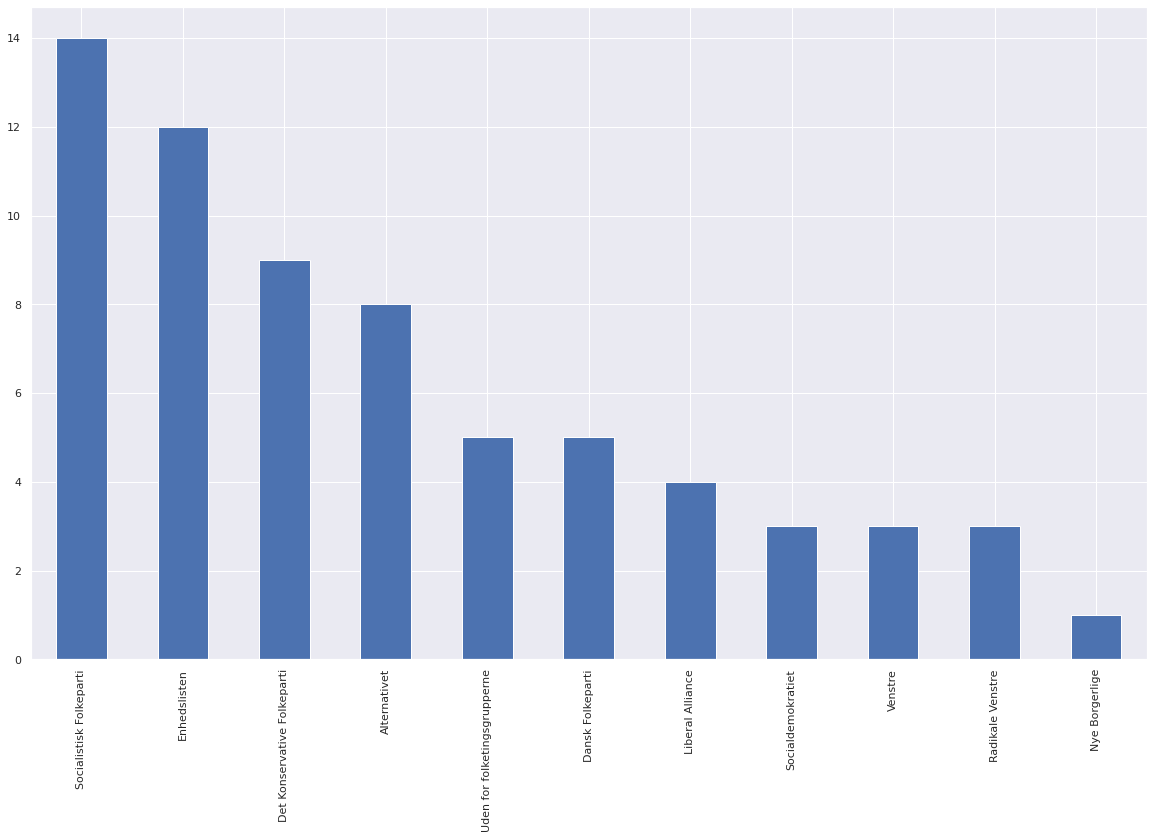

In [13]:
tweets_df_tidy.loc[tweets_df_tidy['tokens'].isin(keywords), 'party'].value_counts().plot.bar()

# ØVELSE 4: Tidy text data (reddit data)

Du skal nu anvende din funktion fra før på alle *kommentarerne* i reddit datasættet (kolonnen `comment_body`)

1. Brug `.apply()` til at anvende din tokenizer funktion på hele reddit datasættet til at lave en tokens kolonne (det kan være en god ide at teste funktionen med en enkelt kommentar først)
2. Brug `.explode()` til at konvertere data til et tidy format
3. Brug `.value_counts()` til at optælle tokens

**Bonus**

- Undersøg, hvor mange gange coronavirus er nævnt (tænkt gerne synonymer med!)